In [80]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import pandas as pd
import os
from glob import glob
from read_data import compute_baseline_mask, add_bl_stat_masks




def plot_data(df, filename,
              plot_blocks=None,
              start_date=None,
              end_date=None):
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.ticker import MaxNLocator

    def plot_column(ax, df, col, linewidth=2.0):
        if col not in df.columns or df[col].dropna().empty:
            return
        
        vals = set(df[col].dropna().unique())
        if (1 in vals or True in vals) and vals <= {0, 1, True, False}:#  если только нули не считаем булевой
            print(f"{col} is bool column (реально маска)")
            x = df['date']
            y1 = np.zeros(len(df))
            y2 = np.full(len(df), 0.8)
            mask = df[col].astype(bool).fillna(False).values
            if len(x) == len(mask):
                ax.fill_between(x, y1, y2, where=mask,
                                color='blue', alpha=0.2, transform=ax.get_xaxis_transform(), label=col)
        else:
            ax.plot(df['date'], pd.to_numeric(df[col], errors='coerce'), label=col, linewidth=linewidth)



    # df['date'] = pd.to_datetime(df['date'])

    if start_date:        
        df = df[df['date'] >= start_date]
    if end_date:  
        df = df[df['date'] <= end_date]

    if plot_blocks is None:
        plot_blocks = [[], [], [], []]
    elif len(plot_blocks) < 4:
        plot_blocks += [[]] * (4 - len(plot_blocks))
    plot_blocks = [[col for col in group if col in df.columns] for group in plot_blocks]

    fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
    for i, ax in enumerate(axes):
        for col in plot_blocks[i]:
            plot_column(ax, df, col)
        if plot_blocks[i]:
            ax.legend(loc='upper left', bbox_to_anchor=(1.12, 1), title=f'Group {i+1}')

    time_span = df['date'].max() - df['date'].min()
    days = time_span.days
    hours = time_span.total_seconds() / 3600

    if days > 30:
        major_locator = mdates.MonthLocator()
        minor_locator = mdates.WeekdayLocator(interval=1)
        major_formatter = mdates.DateFormatter('%d %b\n%Y')
    elif days >= 2:
        major_locator = mdates.DayLocator(interval=max(1, days // 7))
        minor_locator = mdates.DayLocator()
        major_formatter = mdates.DateFormatter('%d %b')
    elif hours >= 6:
        major_locator = mdates.HourLocator(interval=max(1, int(hours / 6)))
        minor_locator = mdates.HourLocator(interval=1)
        major_formatter = mdates.DateFormatter('%H:%M\n%d %b')
    else:
        major_locator = mdates.MinuteLocator(byminute=range(0, 60, 15))
        minor_locator = mdates.MinuteLocator(byminute=range(0, 60, 5))
        major_formatter = mdates.DateFormatter('%H:%M')

    for ax in axes:
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_formatter)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.tick_params(axis='x', which='major', labelsize=9, labelbottom=True)
        ax.tick_params(axis='x', which='minor', length=4, color='gray')
        ax.yaxis.set_major_locator(MaxNLocator(6))
        ax.grid(True, which='both', axis='x', alpha=0.3)
        ax.grid(True, axis='y', alpha=0.3)

    fig.suptitle(filename, y=1.03, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)
    plt.show()

def read_data(
    path, filename,
    delete_nans=False, add_reference=False, verbose=True
):
    import os
    import pandas as pd

    df = pd.read_csv(f'{path}/{filename}')
    if verbose:
        print(f"all data length = {len(df)}")

    # Удаляем timestamp, если есть
    if 'ts' in df.columns:
        df = df.drop(columns=['ts'])

    # Удаление полностью пустых колонок
    empty_cols = [col for col in df.columns if df[col].isna().sum() == len(df)]
    if empty_cols:
        df = df.drop(columns=empty_cols)
        if verbose:
            print(f"Удалены пустые колонки: {empty_cols}")

    # Удаление полностью пустых строк (кроме date)
    if delete_nans:
        cols_to_check = [col for col in df.columns if col != 'date']
        rows_to_delete = df[cols_to_check].isna().all(axis=1).sum()
        if verbose and rows_to_delete > 0:
            print(f"Будет удалено строк: {rows_to_delete}")
        df = df.dropna(subset=cols_to_check, how='all')

    if verbose:
        print(f"final data length = {len(df)}")

    # --- REFERENCE START ---
    if add_reference:
        path_ref = os.path.join(os.path.dirname(path), "field_reference")
        for gas in ['NO2', 'O3']:
            ref_file = os.path.join(path_ref, f"{gas}_ref.csv")
            if os.path.exists(ref_file):
                df_ref = pd.read_csv(ref_file)
                if 'date' not in df_ref.columns:
                    continue
                df_ref['date'] = pd.to_datetime(df_ref['date'])
                value_cols = [col for col in df_ref.columns if col != 'date']
                if value_cols:
                    val_col = value_cols[0]
                    ref_col_name = f"{gas}_ref"
                    df_ref = df_ref.rename(columns={val_col: ref_col_name})
                    df['date'] = pd.to_datetime(df['date'])
                    df = pd.merge(df, df_ref[['date', ref_col_name]], on='date', how='left')
    # --- REFERENCE END ---

    # --- Типизация (опционально) ---
    types = {'bool': [], 'small': [], 'middle': [], 'large': []}
    numeric_cols = [col for col in df.columns if col != 'date' and pd.api.types.is_numeric_dtype(df[col])]
    for col in numeric_cols:
        values = df[col].dropna()
        if values.empty:
            continue
        unique_vals = set(values.unique())
        mean_val = values.mean()
        std_val = values.std()
        if unique_vals <= {0, 1}:
            types['bool'].append(col)
        elif mean_val > 100 or std_val > 50:
            types['large'].append(col)
        elif std_val > 10:
            types['middle'].append(col)
        else:
            types['small'].append(col)
    if verbose:
        print("\n[Типизация переменных]")
        for key, val in types.items():
            print(f"{key.upper():>6}: {val}")

    print(df.columns)
    return df, types





In [81]:
#-------------------------------Lab Data-------------------------------------

path  = "data_example/lab_data"

file_list = sorted([os.path.basename(f) for f in glob(os.path.join(path, "*.csv"))])
file_iter = iter(file_list)

cross_gases_map = {
    'NO2': ['O3'],
    'CO': [],
    'O3': ['NO2'],
    'SO2': ['H2S'],
    'H2S': ['SO2']
}
add_bl_stat = True

G100097E_stat.csv is being read
all data length = 28800
final data length = 28800

[Типизация переменных]
  BOOL: ['COop1_stat_auto', 'COop1_bl_auto', 'NO2op1_stat_auto', 'NO2op1_bl_auto', 'O3op1_stat_auto', 'O3op1_bl_auto', 'stat', 'bl']
 SMALL: ['COop1', 'COop2']
MIDDLE: ['T_THC', 'RH_THC', 'H2S', 'NO2t', 'O3t', 'COt', 'MT', 'MH', 'target_t', 'target_rh']
 LARGE: ['CO', 'NO2', 'SO2', 'NO2op1', 'NO2op2', 'O3op1', 'O3op2', 'temp_O3', 'O3']
Index(['date', 'T_THC', 'RH_THC', 'CO', 'NO2', 'H2S', 'SO2', 'NO2op1',
       'NO2op2', 'NO2t', 'O3op1', 'O3op2', 'O3t', 'COop1', 'COop2', 'COt',
       'MT', 'MH', 'temp_O3', 'O3', 'COop1_stat_auto', 'COop1_bl_auto',
       'NO2op1_stat_auto', 'NO2op1_bl_auto', 'O3op1_stat_auto',
       'O3op1_bl_auto', 'stat', 'bl', 'target_t', 'target_rh'],
      dtype='object')
NO2: estimated contamination = 0.0010
NO2: 18672 baseline (после фильтрации)
NO2: baseline = 18672, stat = 6796, всего = 28800
CO: estimated contamination = 0.0010
CO: 24524 baseline (посл

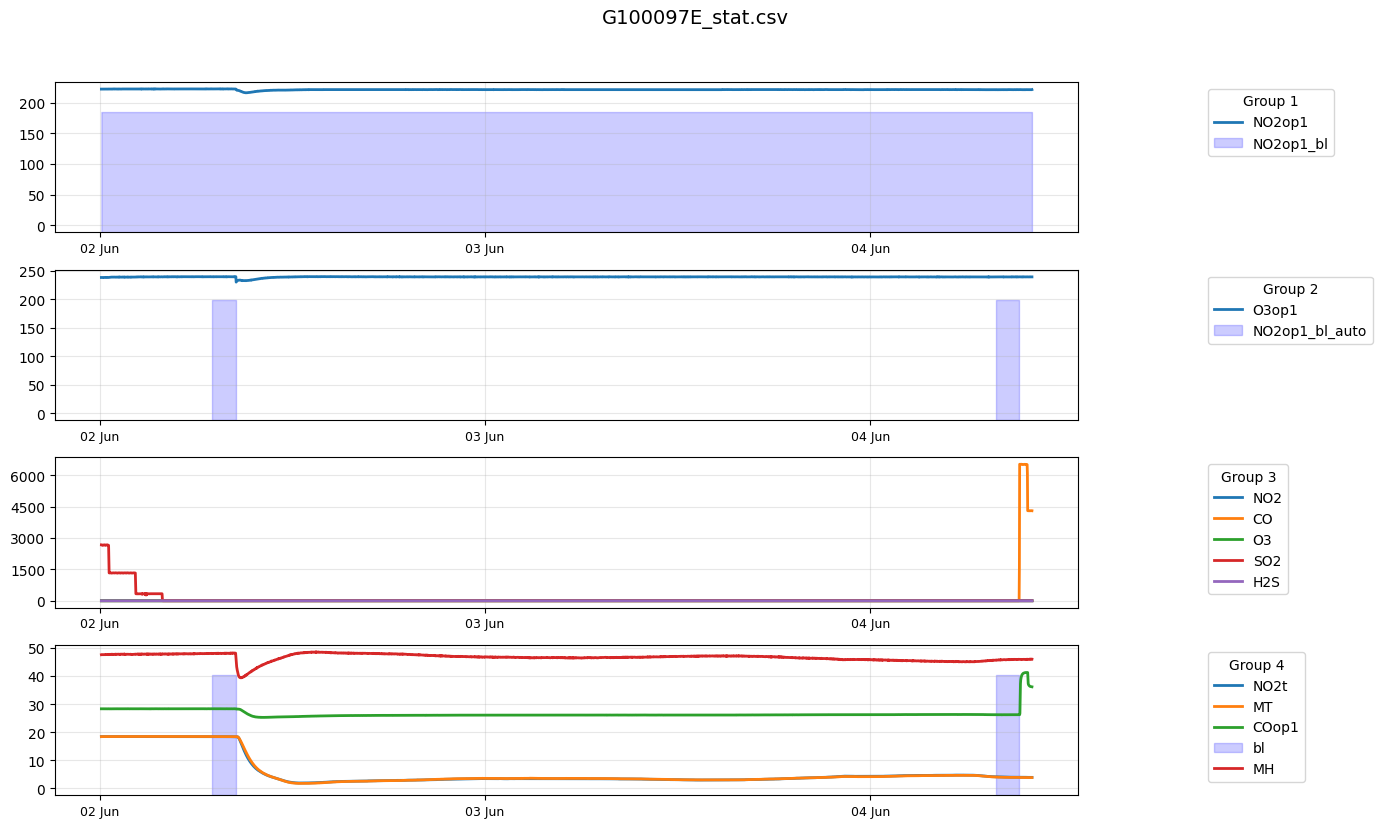

In [103]:

try:
    # filename = next(file_iter)
    print(f"{filename} is being read")
    # filename ='G200075С.csv'  # нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная
    # filename ='G10008A4.csv'  # нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная (нули с эпизодическими скачками)
    # filename ='G10005DA.csv'  присутсвуют длит. периоды без данных
    # filename ='G10006DB.csv'  присутсвуют длит. периоды без данных
    # filename ='G10009DB.csv'  много дрифтов

    # 1. Читаем данные, объединяем референсы (без нарезки масок)
    df, types = read_data(path, filename, delete_nans=False, add_reference= False, verbose=True)



    if add_bl_stat:
            
        df = add_bl_stat_masks(
            df,
            gases=['NO2', 'CO', 'O3', 'SO2', 'H2S'],
            std_thr=1.8, window=7, baseline_eps=0.01,
            use_isolation=True,
            cross_gases_map=cross_gases_map,
            verbose=True
        )



    
    start_date = df['date'].min()
    end_date = df['date'].max()
    start_date = '2025-06-02 00:05:00'
    end_date =  '2025-06-04 10:05:00'

    # df['date'] = pd.to_datetime(df['date'])  
    df['date'] = pd.to_datetime(df['date'])
    freq = 'min'  # или 'H'
    full_range = pd.date_range(df['date'].min(), df['date'].max(), freq=freq)
    df = df.set_index('date').reindex(full_range).rename_axis('date').reset_index()

    tz = df['date'].dt.tz
    sd = pd.to_datetime(start_date)
    ed = pd.to_datetime(end_date)
    if tz is not None:
        if sd.tzinfo is None: sd = sd.tz_localize(tz)
        else: sd = sd.tz_convert(tz)
        if ed.tzinfo is None: ed = ed.tz_localize(tz)
        else: ed = ed.tz_convert(tz)



    # gas = 'SO2'
    # cols_1 = [f'{gas}op1_stat_auto', f'{gas}op1', f'{gas}op2', 'O3']
    # cols_1 = [f'{gas}op1', f'{gas}op2']
    # cols_2 = [gas]
    # cols_3 = ['g1_mh', 'NO2op1_stat']
    # cols_4 = [f'{gas}t', 'stat']
    cols_1 = []
    cols_2 = []
    cols_3 = []
    cols_4 = []

    gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']
    # gases = ['NO2']

    # gases = [ 'CO', 'O3', 'SO2', 'H2S']

    # gases = ['NO2', 'O3', 'SO2', 'H2S']
    # gases = ['NO2',  'SO2', 'H2S']


    for gas in gases:
        if gas in df.columns:
            cols_3.append(gas)   

    cols_4 += [col for col in ['MH'] if col in df.columns]
    cols_4 = ['NO2t', 'MT']
    cols_1 = ['NO2op1','NO2op1_bl']
    cols_2 = ['O3op1','NO2op1_bl_auto']
    cols_4 = ['NO2t', 'MT','COop1', 'bl']
    cols_4 += [col for col in ['MH'] if col in df.columns]



    # cols_1.remove('O3op1')

    plot_data(
        df,
        filename=filename,
        plot_blocks=[cols_1,cols_2,cols_3,cols_4], 
        start_date=start_date,
        end_date=end_date
    )

    
except StopIteration:
    print("Все файлы просмотрены!")

Вот пример как размечен бейслайн у  меня и автобейслайн


![image.png](image.png)



In [ ]:
#-------------------------------Field Data-------------------------------------

# path  = "data_example/lab_data"
path_ref  = "data_example/field_reference"
path  = "data_example/field_data"
file_list = sorted([os.path.basename(f) for f in glob(os.path.join(path, "*.csv"))])
file_iter = iter(file_list)

cross_gases_map = {
    'NO2': ['O3'],
    'CO': [],
    'O3': ['NO2'],
    'SO2': ['H2S'],
    'H2S': ['SO2']
}
add_bl_stat = False

G10005DA.csv is being read
all data length = 137303
Удалены пустые колонки: ['packet_id', 'latitude', 'longitude', 'T station', 'RH', 'p', 'PM2', 'PM10', 'SO2', 'H2S', 'H2Sop1', 'H2Sop2', 'H2St', 'SO2op1', 'SO2op2', 'SO2t', 'g2_mt', 'g2_mh', 'g3_data']
final data length = 137303

[Типизация переменных]
  BOOL: ['CO', 'NO2', 'O3']
 SMALL: ['NO2t', 'O3t', 'COop1', 'COop2', 'COt', 'g1_mt']
MIDDLE: ['g1_mh', 'NO2_ref', 'O3_ref']
 LARGE: ['NO2op1', 'NO2op2', 'O3op1', 'O3op2']
Index(['date', 'CO', 'NO2', 'O3', 'NO2op1', 'NO2op2', 'NO2t', 'O3op1', 'O3op2',
       'O3t', 'COop1', 'COop2', 'COt', 'g1_mt', 'g1_mh', 'NO2_ref', 'O3_ref'],
      dtype='object')


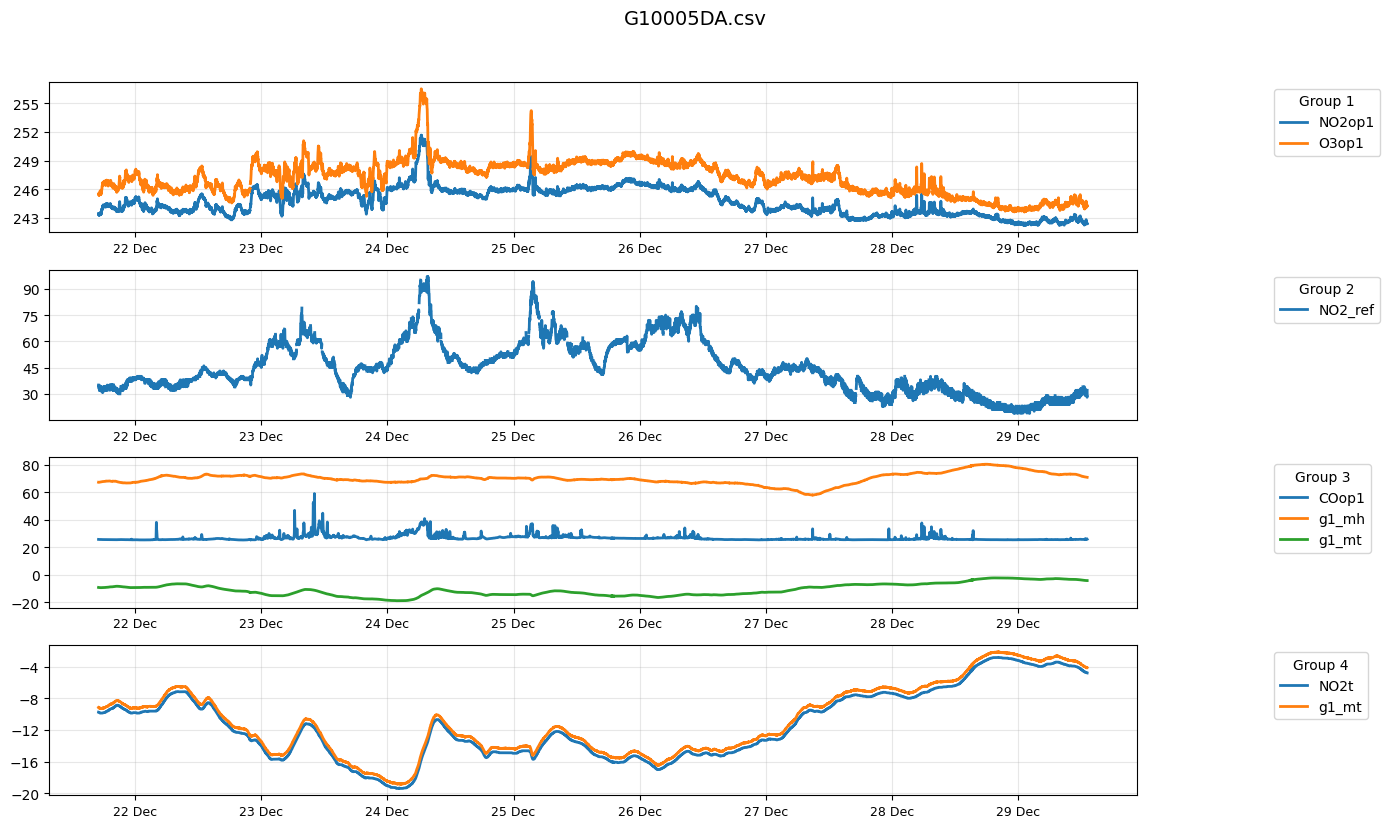

In [79]:

try:
    filename = next(file_iter)
    print(f"{filename} is being read")
    # filename ='G200075С.csv'  # нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная
    # filename ='G10008A4.csv'  # нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная (нули с эпизодическими скачками)
    # filename ='G10005DA.csv'  присутсвуют длит. периоды без данных
    # filename ='G10006DB.csv'  присутсвуют длит. периоды без данных
    # filename ='G10009DB.csv'  много дрифтов

    # 1. Читаем данные, объединяем референсы (без нарезки масок)
    df, types = read_data(path, filename, delete_nans=False, add_reference=True, verbose=True)

    # 2. Нарезаем маски отдельно — ОДНОЙ функцией
    cross_gases_map = {
        'NO2': ['O3'],
        'O3': ['NO2'],
        'SO2': ['H2S'],
        'H2S': ['SO2'],
        'CO': []
    }

    if add_bl_stat:
            
        df = add_bl_stat_masks(
            df,
            gases=['NO2', 'CO', 'O3', 'SO2', 'H2S'],
            std_thr=1.8, window=7, baseline_eps=0.01,
            use_isolation=True,
            cross_gases_map=cross_gases_map,
            verbose=False
        )



    
    start_date = df['date'].min()
    end_date = df['date'].max()
    start_date = '2024-12-22 00:05:00'
    end_date =  '2024-12-29 20:05:00'

    # df['date'] = pd.to_datetime(df['date'])  
    df['date'] = pd.to_datetime(df['date'])
    freq = 'min'  # или 'H'
    full_range = pd.date_range(df['date'].min(), df['date'].max(), freq=freq)
    df = df.set_index('date').reindex(full_range).rename_axis('date').reset_index()

    tz = df['date'].dt.tz
    sd = pd.to_datetime(start_date)
    ed = pd.to_datetime(end_date)
    if tz is not None:
        if sd.tzinfo is None: sd = sd.tz_localize(tz)
        else: sd = sd.tz_convert(tz)
        if ed.tzinfo is None: ed = ed.tz_localize(tz)
        else: ed = ed.tz_convert(tz)



    # gas = 'SO2'
    # cols_1 = [f'{gas}op1_stat_auto', f'{gas}op1', f'{gas}op2', 'O3']
    # cols_1 = [f'{gas}op1', f'{gas}op2']
    # cols_2 = [gas]
    # cols_3 = ['g1_mh', 'NO2op1_stat']
    # cols_4 = [f'{gas}t', 'stat']
    cols_1 = []
    cols_2 = []
    cols_3 = []
    cols_4 = []

    gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']
    # gases = ['NO2']

    # gases = [ 'CO', 'O3', 'SO2', 'H2S']

    # gases = ['NO2', 'O3', 'SO2', 'H2S']
    # gases = ['NO2',  'SO2', 'H2S']


    for gas in gases:
        if f'{gas}op1' in df.columns and f'{gas}op1' in types['large']:
            cols_1.append(f'{gas}op1')

        if f'{gas}op1' in df.columns and (f'{gas}op1' in types['small'] or f'{gas}op1' in types['middle'] ):
            cols_3.append(f'{gas}op1')
        # if f'{gas}op2' in df.columns:
            # cols_1.append(f'{gas}op2')
        # if gas in df.columns:
        #     cols_2.append(gas)

        if f'{gas}t' in df.columns:
            cols_4.append(f'{gas}t')

    if 'g2_mh' in df.columns:
        cols_3.append('g2_mh')
    if 'g2_mt' in df.columns:
        cols_3.append('g2_mt')
    if 'g1_mh' in df.columns:
        cols_3.append('g1_mh')
    if 'g1_mt' in df.columns:
        cols_3.append('g1_mt')
    if 'stat' in df.columns:
        cols_4.append('stat')

    cols_2 += [col for col in ['NO2_ref', 'O3_ref'] if col in df.columns]
    cols_4 = ['NO2t', 'g1_mt']

    # cols_1.remove('O3op1')

    plot_data(
        df,
        filename=filename,
        plot_blocks=[cols_1,cols_2,cols_3,cols_4], 
        start_date=start_date,
        end_date=end_date
    )

    
except StopIteration:
    print("Все файлы просмотрены!")

In [76]:
# mask = (df['date'] >= sd) & (df['date'] <= ed)
# display(df.loc[mask].head(50))



In [35]:
import os
import pandas as pd
from glob import glob

# folder = "data_example/field_data"
# folder = "data_example/lab_data"
folder = "data_example/field_reference"

file_list = sorted([os.path.basename(f) for f in glob(os.path.join(folder, "*.csv"))])

summary = []
comments_dict = {
    'G200075C.csv': 'нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная (нули с эпизодическими скачками)',
    'G10008A4.csv': 'нет информации и влажности g1_mh, с датчиков температуры g1_mt неадекватная (нули с эпизодическими скачками)',
    'G10005DA.csv': 'присутсвуют длит. периоды без данных',
    'G10006DB.csv': 'присутсвуют длит. периоды без данных',
    'G100096B.csv': 'много дрифтов'
}

comments_dict = {}

for filename in file_list:
    df = pd.read_csv(os.path.join(folder, filename))
    if 'date' not in df.columns:
        continue
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    if df['date'].notna().sum() == 0:
        continue
    min_date = df['date'].min().date()
    max_date = df['date'].max().date()
    comment = comments_dict.get(filename, "")

    summary.append({
        "start_date": min_date,
        "end_date": max_date,
        "file": filename,
        "comment": comment
    })

summary_df = pd.DataFrame(summary)

grouped = summary_df.groupby(['start_date', 'end_date'])

result_rows = []
for (start, end), group in grouped:
    for idx, row in group.iterrows():
        result_rows.append({
            "date_range": f"{start} — {end}" if idx == group.index[0] else "",
            "file": row['file'],
            "comment": row['comment']
        })

result_df = pd.DataFrame(result_rows)

display(result_df)

# result_df.to_excel("field_data_files_info.xlsx", index=False)
# result_df.to_excel("lab_data_files_info.xlsx", index=False)
# result_df.to_excel("field_reference_files_info.xlsx", index=False)


,date_range,file,comment
0,2024-01-01 — 2024-11-25,O3_ref.csv,
1,2024-03-19 — 2025-01-01,NO2_ref.csv,
